In [1]:
import matplotlib.pyplot as plt
import numpy as np
from numpy.linalg import norm
import itertools
import copy

import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from model import Symmetric, DeepSets, KNN, KK

%matplotlib inline

In [2]:
batch_size_train = 32
batch_size_test = 32

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
class Overkill(nn.Module):
    def __init__(self, input_dim, h1, h2, h3, output_dim = 1):
        super(Overkill, self).__init__()
        
        self.h1 = h1
        self.h2 = h2
        self.h3 = h3
        self.input_dim = input_dim + 1 #Explicit bias term to simplify path norm
        self.output_dim = output_dim
        
        self.rho = None
        self.phi = None
        self.reinit()
    
    def reinit(self):
        self.phi = nn.Sequential(
            nn.Linear(self.input_dim, self.h1),
            nn.ReLU(),
            nn.Linear(self.h1, self.h1),
            nn.ReLU(),
        )
        self.rho = nn.Sequential(
            nn.Linear(self.h1, self.h2),
#             nn.BatchNorm1d(self.h2),
            nn.ReLU(),
            nn.Linear(self.h2, self.h3),
#             nn.BatchNorm1d(self.h3),
            nn.ReLU(),
            nn.Linear(self.h3, self.output_dim)
        )
    
    def forward(self, x):        
        batch_size, input_set_dim, input_dim = x.shape
        
        x = x.view(-1, input_dim)
        z = self.phi(x)
        z = z.view(batch_size, input_set_dim, -1)
        z = torch.mean(z, 1)
        return self.rho(z)
    
    def regularize(self, lamb):
        return 0.

In [4]:
class PointCloud(object):

    def __init__(self, cloud_size):
        self.cloud_size = cloud_size

    def __call__(self, image):

        flat = image.flatten()
        flat = (flat > 0.5).float() * flat
        
        vertex_count = torch.nonzero(flat).shape[0]
        
        size = min(self.cloud_size, vertex_count)
        
        args = torch.argsort(flat)[-size:].int()
        args = args[torch.randperm(size)]
        if size < self.cloud_size:
            repeat = self.cloud_size // size + 1
            args = args.repeat(repeat)[:self.cloud_size]
        
        
        rows = (args / 28.).int()
        cols = torch.fmod(args, 28)
        
        image = torch.zeros(self.cloud_size, 4)
        
        image[:,0] = (rows - 14) / 28.
        image[:,1] = (cols - 14) / 28.
        image[:,2] = flat[args.long()]
        image[:,3] = 1 #bias term

        return image

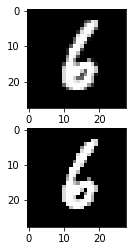

In [5]:
###TEST

train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('data', train=True, download=True,
                             transform=torchvision.transforms.ToTensor()
                             ),
  batch_size=batch_size_train, shuffle=True)

examples = enumerate(train_loader)
batch_idx, (image, y) = next(examples)

image = image[0][0]
cloud_size = 200
x = PointCloud(cloud_size)(image)
rows = 28 * x[:,0] + 14
cols = 28 * x[:,1] + 14

new_im = torch.zeros_like(image)

for i in range(cloud_size):
    r = rows[i].int().item()
    c = cols[i].int().item()
    new_im[r,c] = x[i,2].item()

plt.subplot(2,1,1)
plt.imshow(image, cmap='gray', interpolation='none')
plt.subplot(2,1,2)
plt.imshow(new_im, cmap='gray', interpolation='none')        

In [6]:
cloud_size = 200
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('data', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                                 PointCloud(cloud_size)
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('data', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                                 PointCloud(cloud_size)
                             ])),
  batch_size=batch_size_test, shuffle=True)

print(len(train_loader))
print(len(test_loader))

1875
313


torch.Size([32, 200, 4])
torch.Size([32])


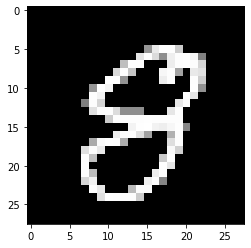

In [7]:
examples = enumerate(train_loader)
batch_idx, (batch_x, batch_y) = next(examples)
print(batch_x.shape)
print(batch_y.shape)

x = batch_x[0]

image = torch.zeros((28, 28))
for i in range(x.shape[0]):
    r = (28 * x[i,0] + 14).int().item()
    c = (28 * x[i,1] + 14).int().item()
    image[r,c] = x[i,2]
    
plt.imshow(image, cmap='gray', interpolation='none')

In [8]:
def train(model, dataloader, iterations, lamb = 0.1, lr = 0.003):
    criterion = nn.CrossEntropyLoss()
    
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=lr)


    losses = []
    for i in range(iterations):
        print("iter", i)
        iter_losses = []
        for batch_idx, (x, y) in enumerate(dataloader):
            x = x.to(device)
            y = y.to(device)
            
            outputs = model(x)
            loss = criterion(outputs, y)

            optimizer.zero_grad()
            loss += model.regularize(lamb)
            loss.backward()
            optimizer.step()

            losses.append(loss.item())
            iter_losses.append(loss.item())
        print("iter_loss: ", np.mean(np.array(iter_losses)))
    
    return losses

def test(model, dataloader):
    model.eval()
    
    correct = 0.
    total = 0.
    
    for batch_idx, (x, y) in enumerate(dataloader):
        x = x.to(device)
        y = y.to(device)
        outputs = model(x)
        preds = torch.argmax(outputs, dim = 1)
        correct += preds.eq(y).sum()
        total += y.shape[0]
    
    return 1 - (correct / total)

In [9]:
def cross_validate(model, dataloader, iterations, lambs, verbose):
    models = []
    for lamb in lambs:
        model_copy = copy.deepcopy(model)
        losses = train(model_copy, dataloader, iterations, lamb)
        models.append(model_copy)
        if verbose:
            print(losses[::100])
    return models

In [10]:
def compare_models(hidden_dim, iterations, input_dim = 3, verbose = False):
        
    f1 = Symmetric(input_dim, hidden_dim, hidden_dim, 10)
    f2 = KNN(input_dim, hidden_dim, hidden_dim, 10)
    f3 = KK(input_dim, hidden_dim, hidden_dim, 10)

    f1.__name__ = "S1"
    f2.__name__ = "S2"
    f3.__name__ = "S3"

    models = [f1, f2, f3]
    
    lambs = [0., 1e-6, 1e-4, 1e-2]

    for model in models:
        print("model", model.__name__)
        cv_models = cross_validate(model, train_loader, iterations, lambs, verbose)
        
        validation_errors = np.zeros_like(lambs)
        for i, cv_model in enumerate(cv_models):
            validation_errors[i] = test(cv_model, train_loader)
        
        i = np.argmin(validation_errors)
        lamb = lambs[i]
            
        runs = 3
        run_errors = np.zeros(runs)
        for i in range(runs):
            print("run", i)
            model_copy = copy.deepcopy(model)
            model_copy.reinit()
            train(model_copy, train_loader, iterations, lamb)
            run_errors[i] = test(model_copy, test_loader)
        
        mean_error = np.mean(run_errors)
        std_error = np.std(run_errors)
        
        print("mean: {}, std: {}".format(mean_error, std_error))
        
#         if log_plot:
#             plt.semilogy(N_list, mean_error, label = model.__name__)
#         else:
#             plt.plot(N_list, mean_error, label = model.__name__)
#         plt.fill_between(N_list, mean_error - std_error, mean_error + std_error, alpha = 0.2)

    
#     plt.legend()
#     plt.ylim([1e-5, 1e-1]) 
#     plt.xlabel("N")
#     plt.ylabel("Mean Square Error")
#     narrow_str = "Narrow" if narrow else "Wide"
#     plt.title(narrow_str + " generalization for " + objective.__name__)
#     scale_str = "" if not scaleup else "scaled"
#     plt.savefig("plots_high_dim/" + objective.__name__ + "_" + narrow_str + "_" + str(input_dim) + scale_str)
# #     plt.show()
#     plt.close()

In [11]:
# compare_models(100, 3, verbose = True)

In [12]:
input_dim = 3
h1 = 100
h2 = 500
h3 = 500

model = Overkill(input_dim, h1, h2, h3, 10).to(device)
# model = Symmetric(input_dim, h1, h2, 10).to(device)

train(model, train_loader, 50, lamb = 0.0, lr = 0.003)

error = test(model, train_loader)
print("train error: ", error)

error = test(model, test_loader)
print("test error: ", error)

iter 0
iter_loss:  1.5613089074452717
iter 1
iter_loss:  0.7119634001255035
iter 2
iter_loss:  0.5444821759541829
iter 3
iter_loss:  0.465437133872509
iter 4
iter_loss:  0.41835560990174614
iter 5
iter_loss:  0.379733114528656
iter 6
iter_loss:  0.3580512909293175
iter 7
iter_loss:  0.3399294368346532
iter 8
iter_loss:  0.3273130679567655
iter 9
iter_loss:  0.32020504401524863
iter 10
iter_loss:  0.3082508816818396
iter 11
iter_loss:  0.3028236623942852
iter 12
iter_loss:  0.29622552425265314
iter 13
iter_loss:  0.28976431861519814
iter 14
iter_loss:  0.2831877281924089
iter 15
iter_loss:  0.27986823006073636
iter 16
iter_loss:  0.27284333741466205
iter 17
iter_loss:  0.2711389164249102
iter 18
iter_loss:  0.26601546550790467
iter 19


KeyboardInterrupt: 